<a href="https://colab.research.google.com/github/likitha888/python/blob/main/Path_Planning_with_A_and_RRT_in_2D_Grid_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
pip install numpy matplotlib

In [22]:
#2. Common Framework Setup
#2.1 Define Grid Environment
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
import random
import math

# Grid dimensions
GRID_WIDTH = 30
GRID_HEIGHT = 30

# Create obstacle map (1 = obstacle, 0 = free)
def create_map():
    grid = np.zeros((GRID_HEIGHT, GRID_WIDTH))

    # Add rectangular obstacles
    grid[5:15, 10:12] = 1
    grid[15:20, 20:25] = 1
    grid[0:3, :] = 1  # Boundary
    grid[-3:, :] = 1
    grid[:, 0:3] = 1
    grid[:, -3:] = 1

    return grid

grid = create_map()
start = (5, 5)
goal = (25, 25)


In [23]:
#2.2 Visualization Function
def plot_path(grid, path=None, title="Path Planning"):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='binary')

    if path:
        path_x, path_y = zip(*path)
        plt.plot(path_y, path_x, 'r-', linewidth=2)

    plt.plot(start[1], start[0], 'go', markersize=10)  # Start (green)
    plt.plot(goal[1], goal[0], 'mo', markersize=10)   # Goal (magenta)
    plt.title(title)
    plt.grid(True)
    plt.show()


In [24]:
#3. A Algorithm Implementation*

#3.1 Heuristic Function (Euclidean Distance)
def heuristic(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)



In [25]:
#3.2 A Core Algorithm*
def a_star(grid, start, goal):
    neighbors = [(0,1),(1,0),(0,-1),(-1,0),(1,1),(-1,1),(1,-1),(-1,-1)]  # 8-connected

    open_set = PriorityQueue()
    open_set.put((0, start))

    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    while not open_set.empty():
        _, current = open_set.get()

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        for dx, dy in neighbors:
            neighbor = current[0]+dx, current[1]+dy

            # Check bounds and obstacles
            if (0 <= neighbor[0] < GRID_HEIGHT and
                0 <= neighbor[1] < GRID_WIDTH and
                grid[neighbor[0], neighbor[1]] == 0):

                tentative_g = g_score[current] + heuristic(current, neighbor)

                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = tentative_g + heuristic(neighbor, goal)
                    open_set.put((f_score[neighbor], neighbor))

    return None  # No path found


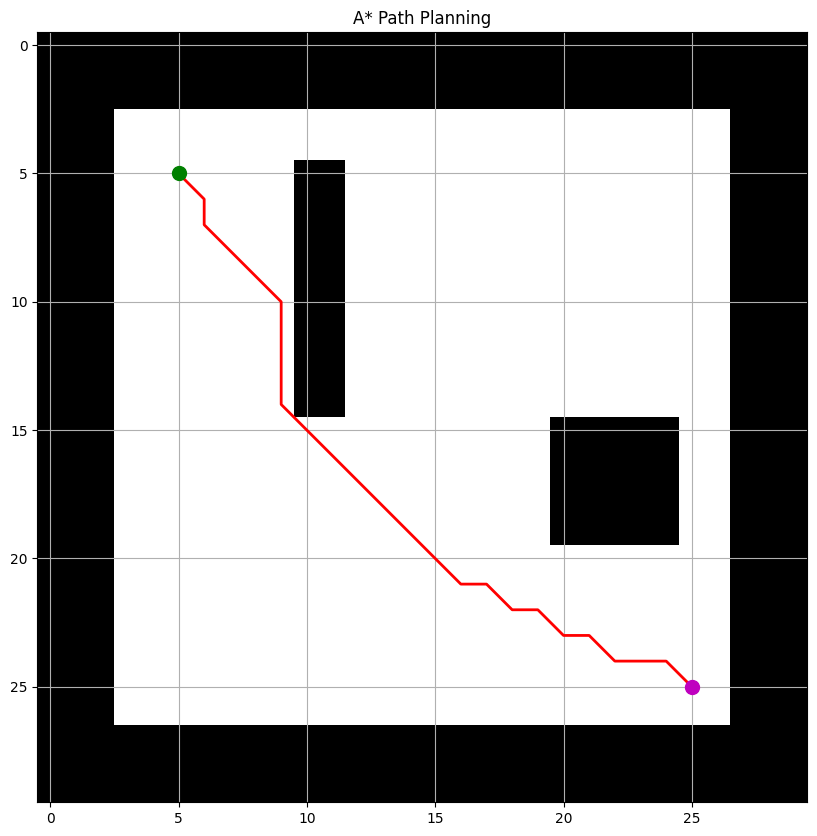

In [26]:
#3.3 Run A*
a_star_path = a_star(grid, start, goal)
plot_path(grid, a_star_path, "A* Path Planning")



In [27]:
#4. RRT Algorithm Implementation

#4.1 RRT Node Structure
class Node:
    def __init__(self, pos):
        self.pos = pos
        self.parent = None


In [28]:
#4.2 RRT Core Algorithm
def rrt(grid, start, goal, max_iter=1000, step_size=2.0):
    nodes = [Node(start)]

    for _ in range(max_iter):
        # Sample random point (90% bias toward goal)
        if random.random() < 0.9:
            rand_pos = goal
        else:
            rand_pos = (random.randint(0, GRID_HEIGHT-1),
                       random.randint(0, GRID_WIDTH-1))

        # Find nearest node
        nearest_node = min(nodes, key=lambda node: heuristic(node.pos, rand_pos))

        # Steer toward random point
        theta = math.atan2(rand_pos[0]-nearest_node.pos[0],
                          rand_pos[1]-nearest_node.pos[1])
        new_pos = (int(nearest_node.pos[0] + step_size * math.sin(theta)),
                   int(nearest_node.pos[1] + step_size * math.cos(theta)))

        # Check collision
        if (0 <= new_pos[0] < GRID_HEIGHT and
            0 <= new_pos[1] < GRID_WIDTH and
            grid[new_pos[0], new_pos[1]] == 0):

            # Add to tree
            new_node = Node(new_pos)
            new_node.parent = nearest_node
            nodes.append(new_node)

            # Check if reached goal
            if heuristic(new_pos, goal) < step_size:
                path = []
                current = new_node
                while current:
                    path.append(current.pos)
                    current = current.parent
                return path[::-1]

    return None  # No path found


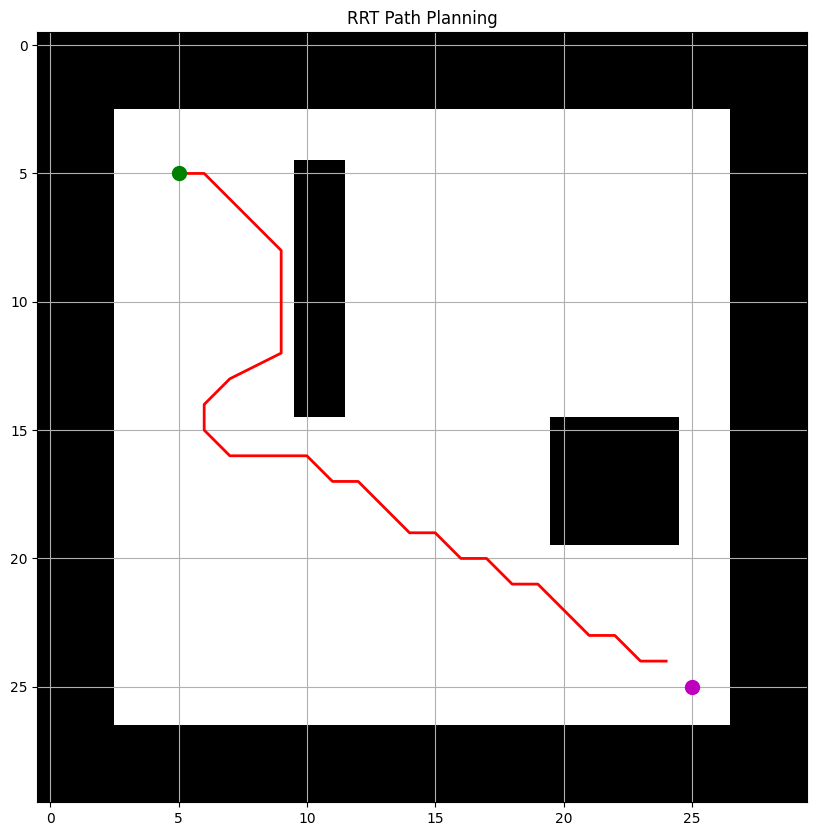

In [29]:
#4.3 Run RRT
rrt_path = rrt(grid, start, goal)
plot_path(grid, rrt_path, "RRT Path Planning")
